In [21]:
import numpy as np
import pandas as pd
from math import ceil, floor
from glob import glob
from tqdm.auto import tqdm
import h5py
import os.path
from scipy import stats
import math

import sys
sys.path.insert(1, '/Users/prullens/Documents/GitHub/scChromTools/local/')
import scChromTools as scct
import scChromUtils as sccu

# Plot settings

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import gaussian, fftconvolve
from matplotlib import ticker as mticker
import pygbrowse
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LinearSegmentedColormap as cmap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FormatStrFormatter
import matplotlib.colors

plt.rcParams["xtick.major.size"] = 7
plt.rcParams["ytick.major.size"] = 7
plt.matplotlib.rcParams['pdf.fonttype'] = 42
plt.rcParams['figure.dpi'] = 150

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

boxprops = {
    'boxprops':{'edgecolor':'k','linewidth':1},
    'medianprops':{'color':'k','linewidth':1},
    'whiskerprops':{'color':'k','linewidth':1},
    'capprops':{'color':'k','linewidth':1}
}

coldict = {'ESCs_d0':'#a8cbeb',
           'ES_d0':'#a8cbeb',
           'ES_d0_fromVitaminC':'#a8cbeb', 
           'VitaminC_d2':'#b4dbc6',
           'VitaminC_d3':'#73c09a', 
           'VitaminC_d4':'#168786', 
           'VitaminC_d5':'#146187', 
           'VitaminC_d6':'#04425b',
           'CAST_EiJ':'#3131dd',
           '129S1_SvImJ':'#b72323'
}

# Global variables

In [3]:
CHROMS = [str(i) for i in list(range(1,20)) + ["X"]]
CHROMSIZES = '/Users/prullens/metadata/mm10_chrom_sizes.tsv'

BINSIZE = 100000
SMOOTH_STDDEV = 150000

BLACKLIST = '/Users/prullens/metadata/mm10.blacklist.bed'
EXPECTED = '/Users/prullens/metadata/mm10_mappability_binsize_%i.hdf5' %BINSIZE

COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

W = gaussian(ceil(SMOOTH_STDDEV / BINSIZE * 6 / 2) * 2 + 1, SMOOTH_STDDEV / BINSIZE)
W /= W.sum()

DAMCASFMT = '/Users/prullens/Documents/projects/DamnChIC/experiments/%s/hdf5/%s.index%02d.DamID2_BC_%03d.129S1_SvImJ_snps_vs_CAST_snps.unique_CAST_snps.top_n_1.event_counts.PE_R1.binsize_100000.hdf5'
DAM129FMT = '/Users/prullens/Documents/projects/DamnChIC/experiments/%s/hdf5/%s.index%02d.DamID2_BC_%03d.129S1_SvImJ_snps_vs_CAST_snps.unique_129S1_SvImJ_snps.top_n_1.event_counts.PE_R1.binsize_100000.hdf5'

CHICCASFMT = '/Users/prullens/Documents/projects/DamnChIC/experiments/%s/hdf5/%s.index%02d.BC_ChIC_%03d.129S1_SvImJ_snps_vs_CAST_snps.unique_CAST_snps.top_n_1.chic.PE_R1.AT_noTC.event_counts.binsize_100000.hdf5'
CHIC129FMT = '/Users/prullens/Documents/projects/DamnChIC/experiments/%s/hdf5/%s.index%02d.BC_ChIC_%03d.129S1_SvImJ_snps_vs_CAST_snps.unique_129S1_SvImJ_snps.top_n_1.chic.PE_R1.AT_noTC.event_counts.binsize_100000.hdf5'

# Data

_Metadata_

In [4]:
anno8403 = pd.read_csv('/Users/prullens/Documents/projects/DamnChIC/experiments/KIN8403/KIN8403_anno_hoechst.tsv', sep='\t')
anno8403.index = ['KIN8403.index%02d.%03d' %(i,bc) for i,bc in anno8403[['indexnr','barcodenr']].values]

In [5]:
anno8791 = pd.read_csv('/Users/prullens/Documents/projects/DamnChIC/experiments/KIN8791_xci/KIN8791_anno_Xi_hoechst.tsv', sep='\t')
anno8791.index = ['KIN8791_KIN8928_xci.index%02d.%03d' %(i,bc) for i,bc in anno8791[['indexnr','barcodenr']].values]
anno8791['limsid'] = 'KIN8791_KIN8928_xci'

In [6]:
anno = pd.concat([anno8403,anno8791.loc[:,anno8403.columns]])

anno.shape

(10752, 17)

In [7]:
anno = anno[(anno['construct'] == 'Dam-LmnB1') & (anno['antibody'] == 'LmnB1')]

anno.shape

(3072, 17)

_Xi dynamic regions_

In [8]:
lb1_k27_idx = pd.read_csv('/Users/prullens/Documents/projects/DamnChIC/experiments/KIN8164/PR20230209.chrx_lb1_k27_changing_bins_100kb.tsv', header=None)[0].values

lb1_k27_idx.sum()

711

_DamID_

In [11]:
hdf5_list = [DAMCASFMT %(limsid,limsid,i,bc) for limsid,i,bc in anno[['limsid','indexnr','barcodenr']].values]
hdf5_list = [fn for fn in hdf5_list if os.path.isfile(fn)]

oe_dam_cas, depths = scct.compute_oe(hdf5_list, 
                                     BINSIZE, 
                                     CHROMSIZES, 
                                     depth_thrs=200, 
                                     expected=EXPECTED, 
                                     blacklist=BLACKLIST, 
                                     chroms=CHROMS, 
)
anno['dam_counts_cas'] = [depths[bc] if bc in depths else 0 for bc in anno.index]

len(oe_dam_cas)

  0%|          | 0/3071 [00:00<?, ?it/s]

2842

In [13]:
hdf5_list = [DAM129FMT %(limsid,limsid,i,bc) for limsid,i,bc in anno[['limsid','indexnr','barcodenr']].values]
hdf5_list = [fn for fn in hdf5_list if os.path.isfile(fn)]

oe_dam_129, depths = scct.compute_oe(hdf5_list, 
                                     BINSIZE, 
                                     CHROMSIZES, 
                                     depth_thrs=200, 
                                     expected=EXPECTED, 
                                     blacklist=BLACKLIST, 
                                     chroms=CHROMS, 
)
anno['dam_counts_129'] = [depths[bc] if bc in depths else 0 for bc in anno.index]

len(oe_dam_129)

  0%|          | 0/3070 [00:00<?, ?it/s]

2873

_ChIC_

In [15]:
hdf5_list = [CHICCASFMT %(limsid,limsid,i,bc) for limsid,i,bc in anno[['limsid','indexnr','barcodenr']].values]
hdf5_list = [fn for fn in hdf5_list if os.path.isfile(fn)]

oe_chic_cas, depths = scct.compute_oe(hdf5_list, 
                                      BINSIZE, 
                                      CHROMSIZES, 
                                      depth_thrs=200, 
                                      expected=EXPECTED, 
                                      blacklist=BLACKLIST, 
                                      chroms=CHROMS, 
)
anno['chic_counts_cas'] = [depths[bc] if bc in depths else 0 for bc in anno.index]

len(oe_chic_cas)

  0%|          | 0/3072 [00:00<?, ?it/s]

2430

In [16]:
hdf5_list = [CHIC129FMT %(limsid,limsid,i,bc) for limsid,i,bc in anno[['limsid','indexnr','barcodenr']].values]
hdf5_list = [fn for fn in hdf5_list if os.path.isfile(fn)]

oe_chic_129, depths = scct.compute_oe(hdf5_list, 
                                      BINSIZE, 
                                      CHROMSIZES, 
                                      depth_thrs=200, 
                                      expected=EXPECTED, 
                                      blacklist=BLACKLIST, 
                                      chroms=CHROMS, 
)
anno['chic_counts_129'] = [depths[bc] if bc in depths else 0 for bc in anno.index]

len(oe_chic_129)

  0%|          | 0/3072 [00:00<?, ?it/s]

2442

# Plotting

In [17]:
anno_sub = pd.DataFrame(anno.loc[(anno.index.isin(list(oe_dam_cas)) & 
                                  anno.index.isin(list(oe_dam_129)) & 
                                  anno.index.isin(list(oe_chic_cas)) & 
                                  anno.index.isin(list(oe_chic_129)))
])

anno_sub.shape

(2422, 21)

In [18]:
anno_sub.groupby(['construct','antibody','cell_type']).size().to_frame('Cells')

Cells
construct antibody cell_type         
Dam-LmnB1 LmnB1    ES_d0          252
                   VitaminC_d2    258
                   VitaminC_d3   1198
                   VitaminC_d4    228
                   VitaminC_d5    245
                   VitaminC_d6    241

_Manual hoechst thresholding_

In [19]:
libs = anno.index.str[:-4].unique()

s_g2_thrs = dict(zip(libs, [[24_000,35_000],
                            [26_000,38_000],
                            [18_000,25_000],
                            [18_000,25_000],
                            [18_000,26_500],
                            [18_000,26_500],
                            [20_000,28_000],
                            [20_000,27_000]]
))

s_g2_thrs

{'KIN8403.index35': [24000, 35000],
 'KIN8403.index36': [26000, 38000],
 'KIN8791_KIN8928_xci.index30': [18000, 25000],
 'KIN8791_KIN8928_xci.index31': [18000, 25000],
 'KIN8791_KIN8928_xci.index32': [18000, 26500],
 'KIN8791_KIN8928_xci.index33': [18000, 26500],
 'KIN8791_KIN8928_xci.index34': [20000, 28000],
 'KIN8791_KIN8928_xci.index35': [20000, 27000]}

In [26]:
anno_sub['cellcycle_phase_via_hoechst'] = 'G1'
for i,lib in enumerate(libs):
    print(lib)
    idx = anno_sub.index.str[:-4].str.startswith(lib)
    
    _bcs = anno_sub.loc[idx].index[anno_sub.loc[idx,'hoechst'] > s_g2_thrs[lib][0]]
    anno_sub.loc[_bcs,'cellcycle_phase_via_hoechst'] = 'S'

    _bcs = anno_sub.loc[idx].index[anno_sub.loc[idx,'hoechst'] > s_g2_thrs[lib][1]]
    anno_sub.loc[_bcs,'cellcycle_phase_via_hoechst'] = 'G2'

KIN8403.index35
KIN8403.index36
KIN8791_KIN8928_xci.index30
KIN8791_KIN8928_xci.index31
KIN8791_KIN8928_xci.index32
KIN8791_KIN8928_xci.index33
KIN8791_KIN8928_xci.index34
KIN8791_KIN8928_xci.index35


In [27]:
anno_sub.groupby('cellcycle_phase_via_hoechst').size().to_frame('Cells')

,Cells
cellcycle_phase_via_hoechst,
G1,1098
G2,542
S,782


_Downsample day 3_

In [28]:
#to max n cells of other ``cell_type``
n = anno_sub[anno_sub['cell_type'] != 'VitaminC_d3'].groupby(['construct','antibody','cell_type']).size().max()

n

258

In [30]:
_bcs = anno_sub[anno_sub['cell_type'] == 'VitaminC_d3'].index

_bcs.size

1198

In [31]:
np.random.seed(0)

random_choice_idx = np.sort(np.random.choice(np.arange(_bcs.size), size=n, replace=False))

random_choice_idx.size, anno_sub.loc[_bcs[random_choice_idx],'cell_type'].unique()

(258, array(['VitaminC_d3'], dtype=object))

In [32]:
anno_sub = pd.DataFrame(anno_sub[(anno_sub.index.isin(_bcs[random_choice_idx])) | 
                                  (anno_sub['cell_type'] != 'VitaminC_d3')]
)
anno_sub.shape

(1482, 21)

In [33]:
anno_sub.groupby(['construct','antibody','cell_type']).size().to_frame('Cells')

Cells
construct antibody cell_type         
Dam-LmnB1 LmnB1    ES_d0          252
                   VitaminC_d2    258
                   VitaminC_d3    258
                   VitaminC_d4    228
                   VitaminC_d5    245
                   VitaminC_d6    241

In [34]:
anno_sub.groupby('cellcycle_phase_via_hoechst').size().to_frame('Cells')

,Cells
cellcycle_phase_via_hoechst,
G1,637
G2,352
S,493


_____

____

# `scVelo`

In [35]:
import scanpy as sc
import scvelo as scv

____

In [36]:
chrom = 'X'

In [39]:
bcs = anno_sub.index

bcs.size

1482

In [40]:
incl_idx = oe_dam_cas[list(oe_dam_cas)[0]][chrom] > .101

incl_idx.sum()

1511

In [41]:
chic3d = np.array([[fftconvolve(oe_chic_cas[bc][chrom], W, mode='same'),  
                     fftconvolve(oe_chic_129[bc][chrom], W, mode='same')] 
                    for bc in bcs
])

dam3d = np.array([[fftconvolve(oe_dam_cas[bc][chrom], W, mode='same'),  
                    fftconvolve(oe_dam_129[bc][chrom], W, mode='same')] 
                   for bc in bcs
])

chic3d.shape, dam3d.shape

((1482, 2, 1711), (1482, 2, 1711))

In [42]:
dam2d = dam3d[:,:,lb1_k27_idx].mean(2)
chic2d = chic3d[:,:,lb1_k27_idx].mean(2)

dam2d.shape, chic2d.shape

((1482, 2), (1482, 2))

In [43]:
argsort2d = np.argsort(dam2d, axis=1)[:,::-1]

argsort2d.shape

(1482, 2)

In [49]:
d = {0:'CAST_EiJ',1:'129S1_SvImJ'}

anno_sub['xi_via_damlb1'] = [d[a] for a in argsort2d[:,1]]

anno_sub.groupby('xi_via_damlb1').size().to_frame('Cells')

,Cells
xi_via_damlb1,
129S1_SvImJ,1157
CAST_EiJ,325


___

In [51]:
X = np.log2(np.take_along_axis(dam3d, np.atleast_3d(argsort2d), axis=1)[:,1,:])
y = np.log2(np.take_along_axis(chic3d, np.atleast_3d(argsort2d), axis=1)[:,1,:])

X.shape, y.shape

((1482, 1711), (1482, 1711))

In [52]:
#only take lb1-k27 dynamic regions
X = X[:,lb1_k27_idx]
y = y[:,lb1_k27_idx]

X.shape, y.shape

((1482, 711), (1482, 711))

In [53]:
#``scVelo`` only takes positve floats
X_min = X.min(0).reshape(1,-1)
y_min = y.min(0).reshape(1,-1)

X += abs(X_min)
y += abs(y_min)

In [54]:
adata = sc.AnnData(X=X, 
                   obs=pd.DataFrame(anno_sub.loc[bcs]), 
                   var=pd.DataFrame(index=np.arange(lb1_k27_idx.size)[lb1_k27_idx])
)
adata

AnnData object with n_obs × n_vars = 1482 × 711
    obs: 'indexnr', 'barcodenr', 'cellcycle_phase', 'antibody', '_column', '_row', '_well', 'cell_tracer', 'cell_type', 'cellcount', 'construct', 'plate', 'limsid', 'hoechst', 'normalized_hoechst_intensity', 'cellcycle_phase_via_hoechst', 'bad_hoechst', 'dam_counts_cas', 'dam_counts_129', 'chic_counts_cas', 'chic_counts_129', 'xi_via_damlb1'

In [55]:
sc.pp.regress_out(adata, ['dam_counts_129','dam_counts_cas'])
sc.pp.regress_out(adata, ['xi_via_damlb1'])

In [56]:
sc.tl.pca(adata, svd_solver='arpack')

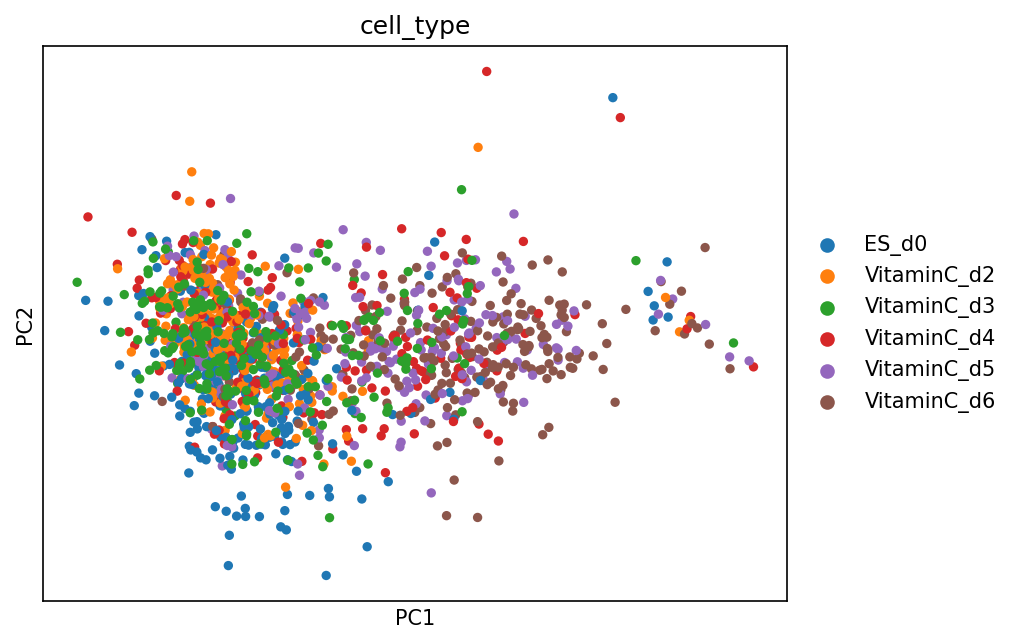

In [57]:
sc.pl.pca(adata, color='cell_type')

In [58]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

adata

AnnData object with n_obs × n_vars = 1482 × 711
    obs: 'indexnr', 'barcodenr', 'cellcycle_phase', 'antibody', '_column', '_row', '_well', 'cell_tracer', 'cell_type', 'cellcount', 'construct', 'plate', 'limsid', 'hoechst', 'normalized_hoechst_intensity', 'cellcycle_phase_via_hoechst', 'bad_hoechst', 'dam_counts_cas', 'dam_counts_129', 'chic_counts_cas', 'chic_counts_129', 'xi_via_damlb1'
    uns: 'pca', 'cell_type_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

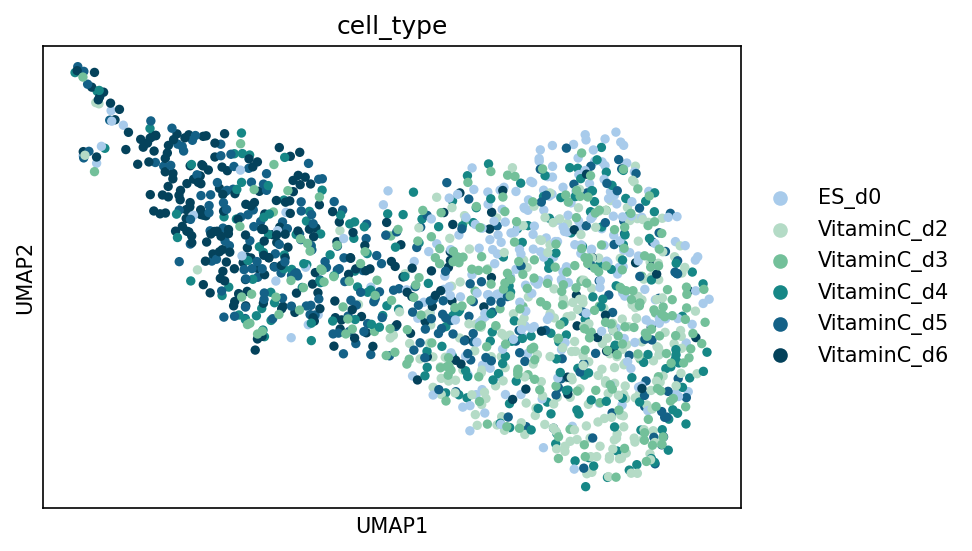

In [61]:
f, ax = plt.subplots(figsize=(6,4))

ax = sc.pl.umap(adata, 
                color='cell_type', 
                palette=[coldict[k] for k in np.unique(adata.obs['cell_type'])],
                cmap='viridis',
                ax=ax
)

____

In [62]:
adata.layers['spliced'] = X
adata.layers['unspliced'] = y

In [63]:
scv.pp.moments(adata, n_pcs=10, n_neighbors=60) #DamID

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [64]:
dm = scv.tl.recover_dynamics(adata)
scv.tl.velocity(adata, vkey='dynamical_velocity', mode='dynamical')

recovering dynamics (using 1/8 cores)


  0%|          | 0/588 [00:00<?, ?gene/s]

    finished (0:02:07) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'dynamical_velocity', velocity vectors for each individual cell (adata.layers)


In [65]:
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/8 cores)


  0%|          | 0/1482 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


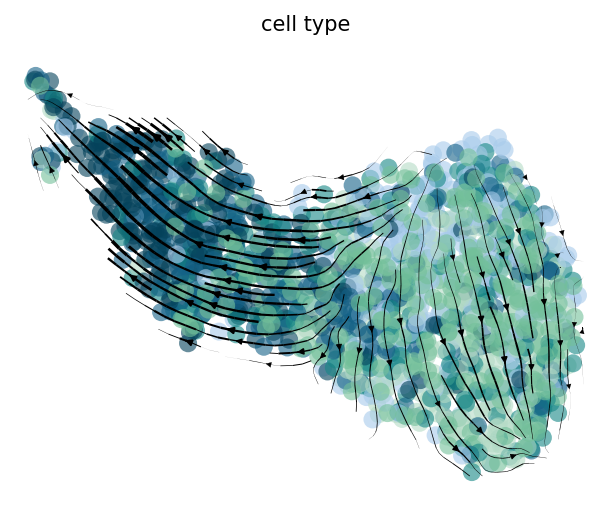

In [66]:
f, ax = plt.subplots(figsize=(5,4))

scv.pl.velocity_embedding_stream(adata, 
                                      color='cell_type', 
                                      alpha=.6,
                                      size=300,
                                 legend_loc=False,
                                 density=1.5,
                                 arrow_size=.6,
                                      ax=ax, 
                                      **{'xlim':(adata.obsm['X_umap'][:,0].min()-.5,
                                                 adata.obsm['X_umap'][:,0].max()+.5), 
                                         'ylim':(adata.obsm['X_umap'][:,1].min()-.5,
                                                 adata.obsm['X_umap'][:,1].max()+.5)}
)

In [70]:
scv.tl.latent_time(adata)

computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


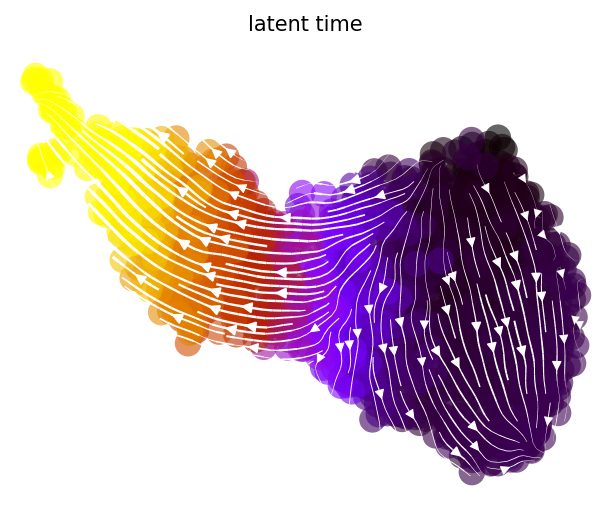

In [71]:
f, ax = plt.subplots(figsize=(5,4))

scv.pl.velocity_embedding_stream(adata, 
                                 color='latent_time', 
                                 color_map='gnuplot',
                                 alpha=.6,
                                 density=0,
                                 arrow_size=0,
                                 arrow_color='white',
                                 colorbar=False,
                                 **{'xlim':(adata.obsm['X_umap'][:,0].min()-.5,
                                            adata.obsm['X_umap'][:,0].max()+.5), 
                                    'ylim':(adata.obsm['X_umap'][:,1].min()-.5,
                                            adata.obsm['X_umap'][:,1].max()+.5)}, 
                                 ax=ax
)

___

In [72]:
indices = [1694,844,591,610,1375]
index = indices[0]

dm = scv.tl.recover_dynamics(adata, var_names=str(index))
scv.tl.velocity(adata, vkey='dynamical_velocity', mode='dynamical')

recovering dynamics (using 1/8 cores)
    finished (0:00:00) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)

outputs model fit of gene: 1694
computing velocities
    finished (0:00:00) --> added 
    'dynamical_velocity', velocity vectors for each individual cell (adata.layers)


Text(0.5, 1.0, 'bin844')

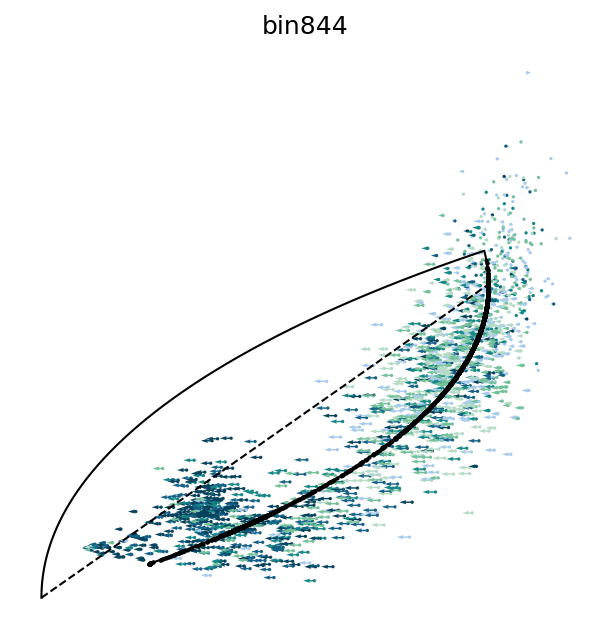

In [78]:
index = 844
vkey = 'dynamical_velocity'

f, ax = plt.subplots(figsize=(5,5),)

X = np.ravel(adata[:,str(index)].layers['Ms'])
y = np.ravel(adata[:,str(index)].layers['Mu'])

sns.scatterplot(x=X, 
                y=y, 
                hue=adata.obs['cell_type'],
                hue_order=np.unique(adata.obs['cell_type']),
                palette=[coldict[k] for k in np.unique(adata.obs['cell_type'])],
                s=2.5,
                edgecolor='k',
                linewidth=0
)

dx = np.ravel(adata[:, str(index)].layers[vkey])
dy = np.ravel(adata[:, str(index)].layers[vkey])
dy = np.zeros(adata.n_obs)

X = np.stack([X, y]).T
V = np.stack([dx, dy]).T

d = dict(zip(np.unique(adata.obs['cell_type']), np.arange(np.unique(adata.obs['cell_type']).size)))
ax.quiver(X[:, 0], 
          X[:, 1], 
          V[:, 0], 
          V[:, 1], 
          [d[k] for k in adata.obs['cell_type']], 
          cmap=cmap.from_list('cbar',[coldict[k] for k in d]), 
          edgecolor='k', 
          linewidth=0
)

ax = scv.pl.scatter(adata, 
                    basis=str(index),
                    show_assignments=False, 
                    size=0,
                    ax=ax, 
                    title='',
                    colorbar=False, 
                    edgecolor='k',
                    linecolor='k',
                    xlabel='', 
                    ylabel='', 
                    show=False
)

ax.get_legend().remove()

ax.spines[['right','bottom','left','top']].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('bin%i' %index)

Text(0.5, 1.0, 'bin844')

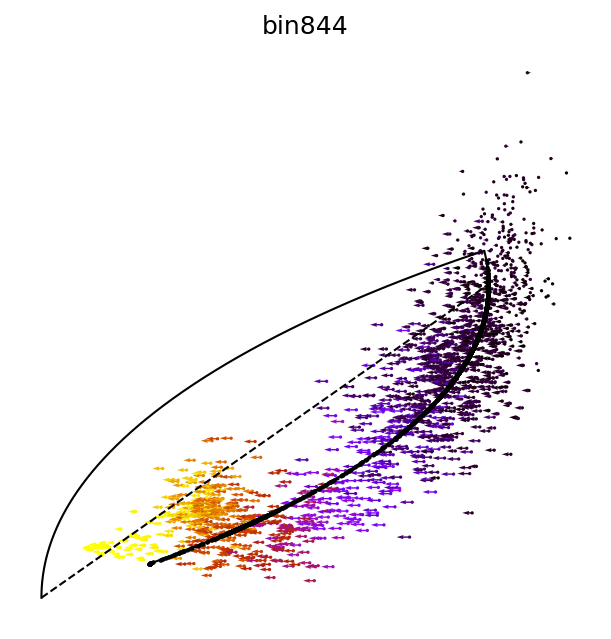

In [80]:
index = 844
vkey = 'dynamical_velocity'

f, ax = plt.subplots(figsize=(5,5))

X = np.ravel(adata[:,str(index)].layers['Ms'])
y = np.ravel(adata[:,str(index)].layers['Mu'])

ax.scatter(X, 
           y, 
           c=adata.obs['latent_time'],
           cmap='gnuplot',
           s=2.5,
           edgecolor='k',
           linewidth=0
)

dx = np.ravel(adata[:, str(index)].layers[vkey])
dy = np.ravel(adata[:, str(index)].layers[vkey])
dy = np.zeros(adata.n_obs)

X = np.stack([X, y]).T
V = np.stack([dx, dy]).T

d = dict(zip(np.unique(adata.obs['cell_type']), np.arange(np.unique(adata.obs['cell_type']).size)))
ax.quiver(X[:, 0], 
          X[:, 1], 
          V[:, 0], 
          V[:, 1], 
          adata.obs['latent_time'], 
          cmap='gnuplot', 
          edgecolor='k', 
          linewidth=0
)

ax = scv.pl.scatter(adata, 
                    basis=str(index),
                    show_assignments=False, 
                    size=0,
                    ax=ax, 
                    title='',
                    colorbar=False, 
                    edgecolor='k',
                    linecolor='k',
                    xlabel='', 
                    ylabel='', 
                    show=False
)

ax.get_legend().remove()

ax.spines[['right','bottom','left','top']].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('bin%i' %index)

___

In [81]:
smooth_stddev = 350_000
w = gaussian(ceil(smooth_stddev / BINSIZE * 6 / 2) * 2 + 1, smooth_stddev / BINSIZE)
w /= w.sum()

In [82]:
dam3d = np.array([[fftconvolve(oe_dam_cas[bc][chrom], w, mode='same'),
                          fftconvolve(oe_dam_129[bc][chrom], w, mode='same')] 
                         for bc in bcs]
)
chic3d = np.array([[fftconvolve(oe_chic_cas[bc][chrom], w, mode='same'),
                           fftconvolve(oe_chic_129[bc][chrom], w, mode='same')] 
                          for bc in bcs]
)

dam3d.shape, chic3d.shape

((1482, 2, 1711), (1482, 2, 1711))

In [84]:
X = np.log2(np.take_along_axis(dam3d, np.atleast_3d(argsort2d), axis=1)[:,1,:])
y = np.log2(np.take_along_axis(chic3d, np.atleast_3d(argsort2d), axis=1)[:,1,:])

X.shape, y.shape

((1482, 1711), (1482, 1711))

In [85]:
dam1d = np.take_along_axis(dam2d, argsort2d, axis=1)[:,1]

dam1d.shape

(1482,)

Text(0, 0.5, 'log$_{{{2}}}$(OE)')

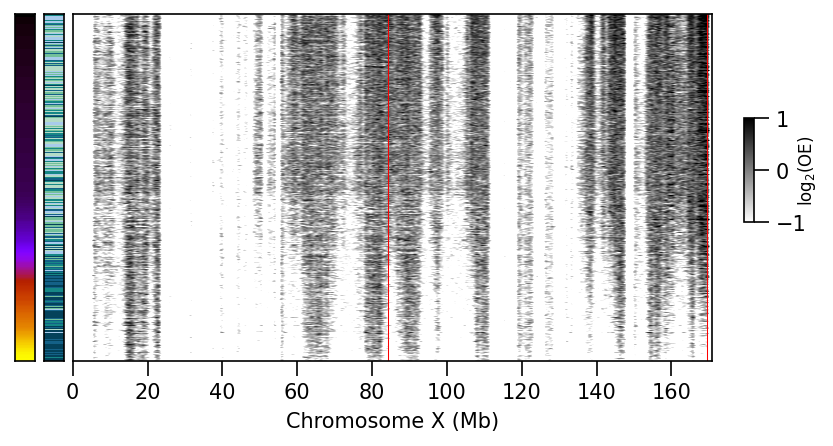

In [87]:
_idx = np.take_along_axis(dam2d, argsort2d, axis=1)[:,1] > np.percentile(dam1d, 2)
_argsort = np.argsort(adata.obs['latent_time'][_idx])

xaxis = np.arange(0,X.shape[1]*BINSIZE,BINSIZE) / 1e6

f, ax = plt.subplots(1, 3, figsize=(6,3), gridspec_kw={'width_ratios':[.03,.03,.97],'wspace':.04})

ax[0].pcolorfast(adata.obs['latent_time'][_idx][_argsort].values.reshape(-1,1), 
                 vmin=0,
                 vmax=1,
                 cmap='gnuplot')

d = dict(zip(np.unique(adata.obs['cell_type']), range(6)))
ax[1].pcolorfast(np.array([d[k] for k in adata.obs['cell_type'][_idx][_argsort]]).reshape(-1,1), 
                 cmap=cmap.from_list('cbar',[coldict[k] for k in d])
)

im = ax[2].imshow(X[_idx][_argsort], 
          aspect='auto', 
          cmap='binary', 
          vmin=-1, 
          vmax=1, 
          extent=np.hstack([xaxis[[0,-1]], X.shape[0], 0])
)

ax[2].set_xlabel('Chromosome %s (Mb)' %chrom)
#ax[1].set_ylabel('Latent time')

ax[2].axvline(84.4, lw=.5, color='r')
ax[2].axvline(169.4, lw=.5, color='r')

ax[0].set_yticks([])
ax[2].set_yticks([])
ax[0].set_xticks([])
ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[1].set_yticks([])
ax[1].set_xticks([])

axins = inset_axes(ax[2],
   width="1%",  # width = 5% of parent_bbox width
   height="30%",  # height : 50%
   loc='lower left',
   bbox_to_anchor=(1.05, .4, 1.5, 1),
   bbox_transform=ax[2].transAxes,
   borderpad=0,
   )
cbar = f.colorbar(im, ax=ax[2], cax=axins, pad=.06, ticks=[-1,0,1])
cbar.ax.set_ylabel('log$_{{{2}}}$(OE)', fontsize=8, labelpad=-5)

Text(0, 0.5, 'Xi scaled OE')

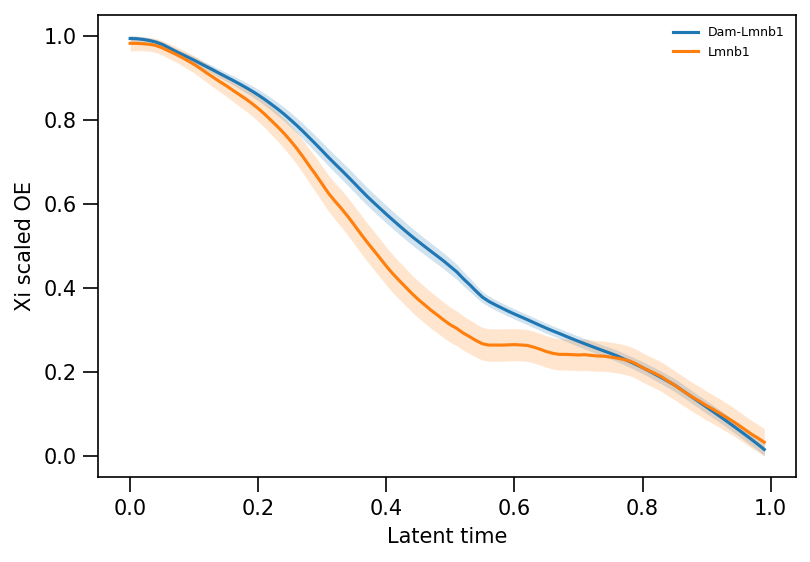

In [91]:
_argsort = np.argsort(adata.obs['latent_time'])

f, ax = plt.subplots(figsize=(6,4),) 

for i,_2d in enumerate([dam2d,chic2d]):
    X = adata.obs['latent_time'][_argsort]
    y = np.take_along_axis(_2d, argsort2d, axis=1)[:,1][_argsort]
    xhat, yhat, yhat_sem = sccu.RNR(X, y, _RADIUS=.1, step=.01)
    
    yhat_sem_min = ((yhat - yhat_sem) - (yhat - yhat_sem).min()) / ((yhat + yhat_sem).max() - (yhat - yhat_sem).min())
    yhat_sem_plus = ((yhat + yhat_sem) - (yhat - yhat_sem).min()) / ((yhat + yhat_sem).max() - (yhat - yhat_sem).min())
    yhat = (yhat - (yhat - yhat_sem).min()) / ((yhat + yhat_sem).max() - (yhat - yhat_sem).min())
    
    ax.fill_between(xhat, yhat_sem_min, yhat_sem_plus, color=COLORS[i], alpha=.2, lw=False)
    ax.plot(xhat, yhat, color=COLORS[i], label=['Dam-Lmnb1','Lmnb1'][i])
    
ax.legend(prop={'size':6}, frameon=False)
ax.set_xlabel('Latent time')
ax.set_ylabel('Xi scaled OE')

_____

In [92]:
X, y = adata.obsm['X_umap'].T
dam1d = np.take_along_axis(dam2d, argsort2d, axis=1)[:,1]
chic1d = np.take_along_axis(chic2d, argsort2d, axis=1)[:,1]

#n-nearest neighbors 
n = 75

a = np.abs(X - X.reshape(-1,1))
b = np.abs(y - y.reshape(-1,1))
ab = a**2 + b**2
c = np.sqrt(ab)

knn_argsort2d = np.argsort(c, axis=1)

dam1d_take_along_axis = np.take_along_axis(np.repeat(dam1d, adata.shape[0]).reshape(adata.shape[0],-1).T, 
                                           knn_argsort2d[:,:n], 
                                           axis=1
)
dam1d_smooth = dam1d_take_along_axis.mean(1)

chic1d_take_along_axis = np.take_along_axis(np.repeat(chic1d, adata.shape[0]).reshape(adata.shape[0],-1).T, 
                                            knn_argsort2d[:,:n], 
                                            axis=1
)
chic1d_smooth = chic1d_take_along_axis.mean(1)

____

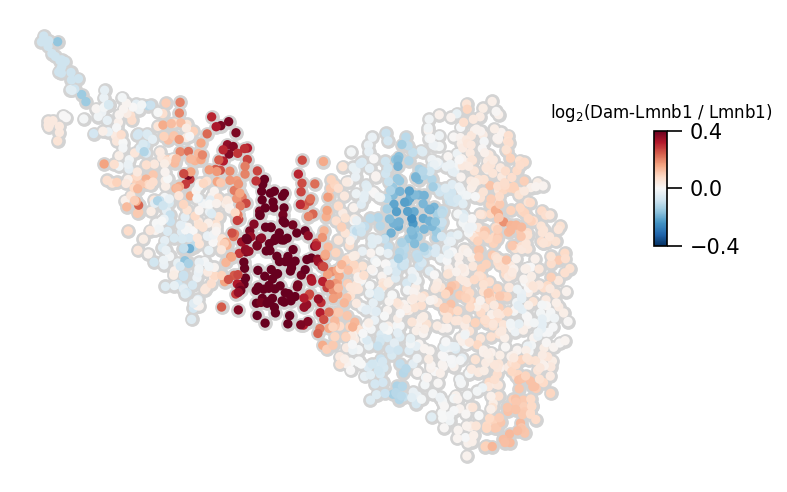

In [94]:
dam1d_smooth_scaled = sccu.mmscale(dam1d_smooth)
chic1d_smooth_scaled = sccu.mmscale(chic1d_smooth)

l2fc = np.log2((dam1d_smooth_scaled + .1) / (chic1d_smooth_scaled + .1))

f, ax = plt.subplots(figsize=(5,4), )

ax.scatter(adata.obsm['X_umap'][:,0], 
           adata.obsm['X_umap'][:,1],
           color='lightgrey',
           s=50,
           linewidth=0, 
           edgecolor='k',
)

sct = ax.scatter(adata.obsm['X_umap'][:,0], 
                 adata.obsm['X_umap'][:,1],
                 c=l2fc,
                 cmap='RdBu_r',
                 s=20,
                 vmin=-.4, 
                 vmax=.4,
                 linewidth=0, 
                 edgecolor='k',
)

axins = inset_axes(ax,
                   width="1.5%",  
                   height="25%",
                   loc='lower left',
                   bbox_to_anchor=(1.1, .5, 1.5, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0,
                   )
cbar = f.colorbar(sct, ax=ax, cax=axins, orientation='vertical', ticks=[-.4,0,.4], pad=.06)
cbar.ax.set_title('log$_{{{2}}}$(Dam-Lmnb1 / Lmnb1)', fontsize=8)

# ax.set_xlabel('UMAP1')
# ax.set_ylabel('UMAP2')

ax.set_yticks([])
ax.set_xticks([])
ax.spines[['right','bottom','left','top']].set_visible(False)

_____

In [95]:
np.random.seed(4)
niter = 100

order = ['G1','S','G2']

_knn_zscore = np.zeros((adata.shape[0],3))
for i0,_knn in enumerate(tqdm(knn_argsort2d[:,:n])):
    obs = adata.obs.iloc[_knn]['cellcycle_phase_via_hoechst']
    _unique = np.unique(obs, return_counts=True)
    obs_dict = dict(zip(order, [0,0,0]))
    for k,v in zip(_unique[0],_unique[1]):
        obs_dict[k] = v
    obscounts = np.array(list(obs_dict.values()))
    
    randcounts = np.zeros((niter,3))
    for i in range(niter):
        randdraw = np.random.choice(adata.obs['cellcycle_phase_via_hoechst'], size=n, replace=False)
        _unique = np.unique(randdraw, return_counts=True)
        randdraw_dict = dict(zip(order, [0,0,0]))
        for k,v in zip(_unique[0],_unique[1]):
            randdraw_dict[k] = v
        randcounts[i] = list(randdraw_dict.values())

    z = (obscounts - randcounts.mean(0)) / randcounts.std(0)
    _knn_zscore[i0] = z

  0%|          | 0/1482 [00:00<?, ?it/s]

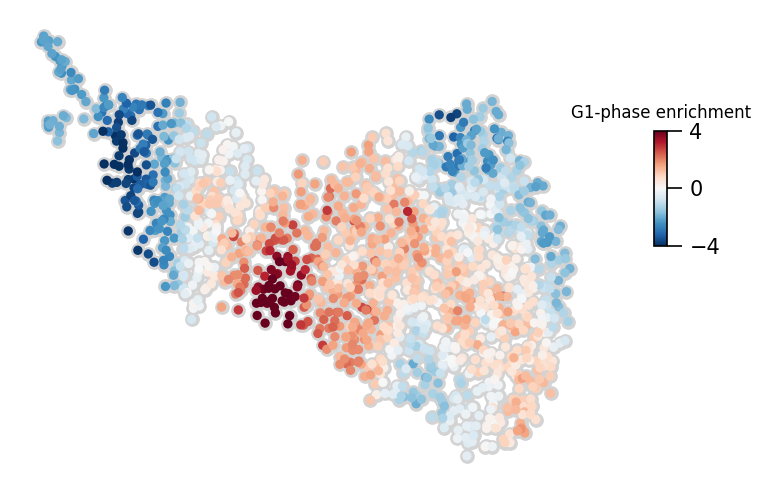

In [97]:
f, ax = plt.subplots(figsize=(5,4),)

ax.scatter(adata.obsm['X_umap'][:,0], 
           adata.obsm['X_umap'][:,1],
           color='lightgrey',
           s=50,
           linewidth=0, 
           edgecolor='k',
)

sct = ax.scatter(adata.obsm['X_umap'][:,0], 
                 adata.obsm['X_umap'][:,1],
                 c=_knn_zscore[:,0],
                 cmap='RdBu_r',
                 s=20,
                 vmin=-4,
                 vmax=4,
                 linewidth=0, 
                 edgecolor='k',
)

axins = inset_axes(ax,
                   width="1.5%",  
                   height="25%",
                   loc='lower left',
                   bbox_to_anchor=(1.1, .5, 1.5, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0,
                   )
cbar = f.colorbar(sct, ax=ax, cax=axins, orientation='vertical', ticks=[-4,0,4], pad=.06)
cbar.ax.set_title('G1-phase enrichment', fontsize=8)

ax.set_yticks([])
ax.set_xticks([])
ax.spines[['right','bottom','left','top']].set_visible(False)

____

Text(0, 0.5, 'Latent time')

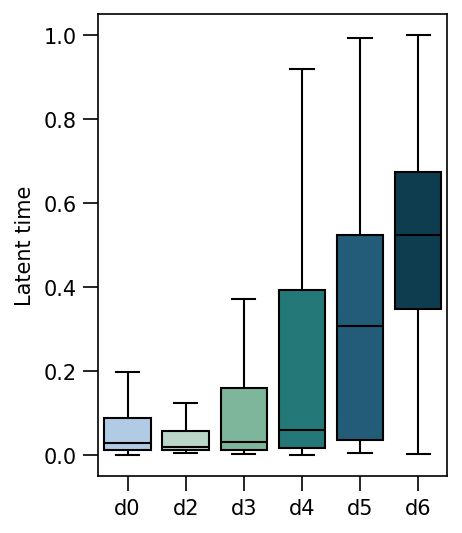

In [103]:
f, ax = plt.subplots(figsize=(3,4),)

sns.boxplot(x=adata.obs['cell_type'].values,
            y=adata.obs['velocity_pseudotime'], 
            order=np.unique(adata.obs['cell_type']), 
            palette=[coldict[k] for k in np.unique(adata.obs['cell_type'])], 
            linewidth=1,
            fliersize=0,
            **boxprops
)

ax.set_xticklabels(pd.Series(np.unique(adata.obs['cell_type'])).str.split('_').str[-1])
ax.set_ylabel('Latent time')

____

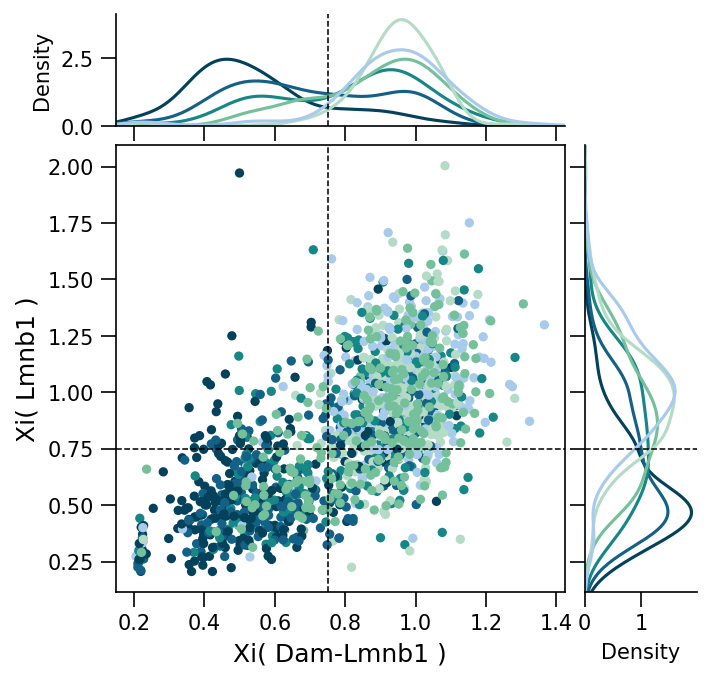

In [104]:
X = np.take_along_axis(dam2d, argsort2d, axis=1)[:,1]
y = np.take_along_axis(chic2d, argsort2d, axis=1)[:,1]

f, ax = plt.subplots(2, 2, figsize=(5,5), gridspec_kw={'height_ratios':[.2,.8],
                                                       'width_ratios':[.8,.2],
                                                       'hspace':.07,
                                                       'wspace':.07}, 
)

sns.scatterplot(x=X, 
                y=y, 
                hue=adata.obs['cell_type'], 
                hue_order=np.unique(adata.obs['cell_type'])[::-1], 
                palette=[coldict[k] for k in np.unique(anno_sub['cell_type'])][::-1],
                s=20, 
                lw=0, 
                ax=ax[1,0]
)
sns.kdeplot(x=X, 
            hue=adata.obs['cell_type'], 
            hue_order=np.unique(adata.obs['cell_type']), 
            palette=[coldict[k] for k in np.unique(anno_sub['cell_type'])],
            ax=ax[0,0], 
            common_norm=False
)
sns.kdeplot(y=y, 
            hue=adata.obs['cell_type'], 
            hue_order=np.unique(adata.obs['cell_type']), 
            palette=[coldict[k] for k in np.unique(anno_sub['cell_type'])],
            ax=ax[1,1], 
            common_norm=False
)

ax[1,0].set_xlabel('Xi( Dam-Lmnb1 )', fontsize=12)
ax[1,0].set_ylabel('Xi( Lmnb1 )', fontsize=12)
ax[1,0].legend(prop={'size':6})

ax[0,0].set_xlim(ax[1,0].get_xlim())
ax[1,1].set_ylim(ax[1,0].get_ylim())
ax[1,1].set_yticklabels([])
ax[0,0].set_xticklabels([])
ax[0,1].remove()

ax[0,0].get_legend().remove()
ax[1,0].get_legend().remove()
ax[1,1].get_legend().remove()

ax[0,0].spines[['top','right']].set_visible(False)
ax[1,1].spines[['top','right']].set_visible(False)

for i in range(ax.shape[0]):
    ax[i,0].axvline(.75, lw=.75, color='k', ls='--')
    ax[1,i].axhline(.75, lw=.75, color='k', ls='--')

____

In [105]:
X = np.take_along_axis(dam2d, argsort2d, axis=1)[:,1]
y = np.take_along_axis(chic2d, argsort2d, axis=1)[:,1]

dam1d = np.take_along_axis(dam2d, argsort2d, axis=1)[:,1]
chic1d = np.take_along_axis(chic2d, argsort2d, axis=1)[:,1]

#n-nearest neighbors 
n = 100

a = np.abs(X - X.reshape(-1,1))
b = np.abs(y - y.reshape(-1,1))
ab = a**2 + b**2
c = np.sqrt(ab)

knn_argsort2d = np.argsort(c, axis=1)

dam1d_take_along_axis = np.take_along_axis(np.repeat(dam1d, adata.shape[0]).reshape(adata.shape[0],-1).T, 
                                           knn_argsort2d[:,:n], 
                                           axis=1
)
dam1d_smooth = dam1d_take_along_axis.mean(1)

chic1d_take_along_axis = np.take_along_axis(np.repeat(chic1d, adata.shape[0]).reshape(adata.shape[0],-1).T, 
                                            knn_argsort2d[:,:n], 
                                            axis=1
)
chic1d_smooth = chic1d_take_along_axis.mean(1)

In [106]:
np.random.seed(4)
niter = 100

order = ['G1','S','G2']

_knn_zscore = np.zeros((adata.shape[0],3))
for i0,_knn in enumerate(tqdm(knn_argsort2d[:,:n])):
    obs = adata.obs.iloc[_knn]['cellcycle_phase_via_hoechst']
    _unique = np.unique(obs, return_counts=True)
    obs_dict = dict(zip(order, [0,0,0]))
    for k,v in zip(_unique[0],_unique[1]):
        obs_dict[k] = v
    obscounts = np.array(list(obs_dict.values()))
    
    randcounts = np.zeros((niter,3))
    for i in range(niter):
        randdraw = np.random.choice(adata.obs['cellcycle_phase_via_hoechst'], size=n, replace=False)
        _unique = np.unique(randdraw, return_counts=True)
        randdraw_dict = dict(zip(order, [0,0,0]))
        for k,v in zip(_unique[0],_unique[1]):
            randdraw_dict[k] = v
        randcounts[i] = list(randdraw_dict.values())

    z = (obscounts - randcounts.mean(0)) / randcounts.std(0)
    _knn_zscore[i0] = z

  0%|          | 0/1482 [00:00<?, ?it/s]

Text(0, 0.5, 'Xi( Lmnb1 )')

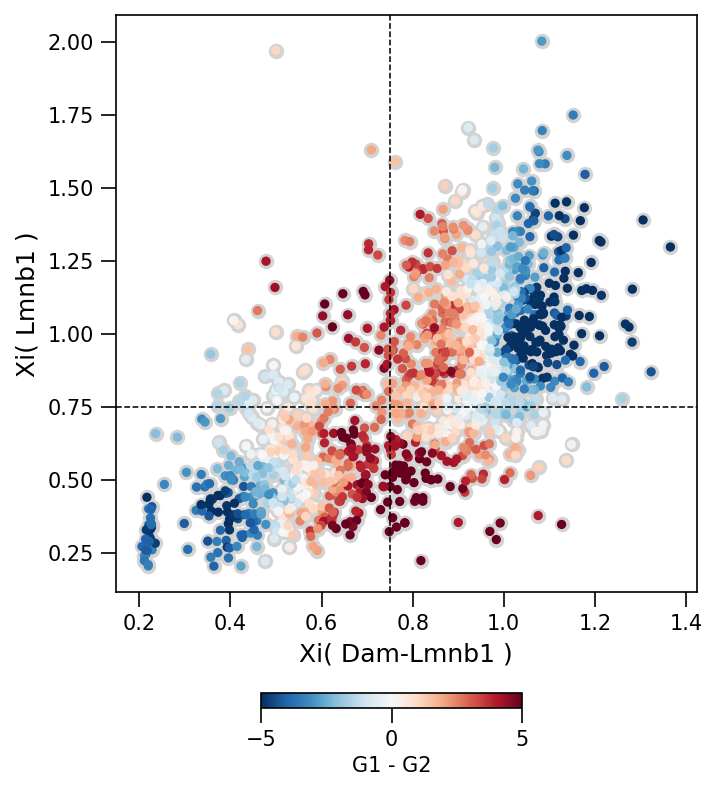

In [109]:
f, ax = plt.subplots(figsize=(5,5), gridspec_kw={'wspace':.2},)

ax.scatter(X, 
           y,
           color='lightgrey',
           s=55,
           lw=0, 
)

sct = ax.scatter(X, 
                 y,
                 c=_knn_zscore[:,0] - _knn_zscore[:,2],
                 cmap='RdBu_r',
                 vmin=-5,
                 vmax=5,
                 s=20,
                 linewidth=0,
)

ax.axvline(.75, lw=.75, color='k', ls='--')
ax.axhline(.75, lw=.75, color='k', ls='--')

axins = inset_axes(ax,
                   width="30%", 
                   height="2.5%",
                   loc='lower left',
                   bbox_to_anchor=(.25, -.2, 1.5, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0,
)
cbar = f.colorbar(sct, ax=ax, cax=axins, orientation='horizontal', ticks=[-5,0,5])
cbar.ax.set_xlabel('G1 - G2', labelpad=3)

ax.set_xlabel('Xi( Dam-Lmnb1 )', fontsize=12)
ax.set_ylabel('Xi( Lmnb1 )', fontsize=12)